In [1]:

import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd




# Path to your solved network
network_path = r"C:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\pypsa-eur\resources\NordicWeightedZonesTestDCLinksx\networks\base_s_70_elec_.nc"

# Load it
n = pypsa.Network(network_path)

# Check network info
print(n)


INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, storage_units, stores


PyPSA Network 'Unnamed Network'


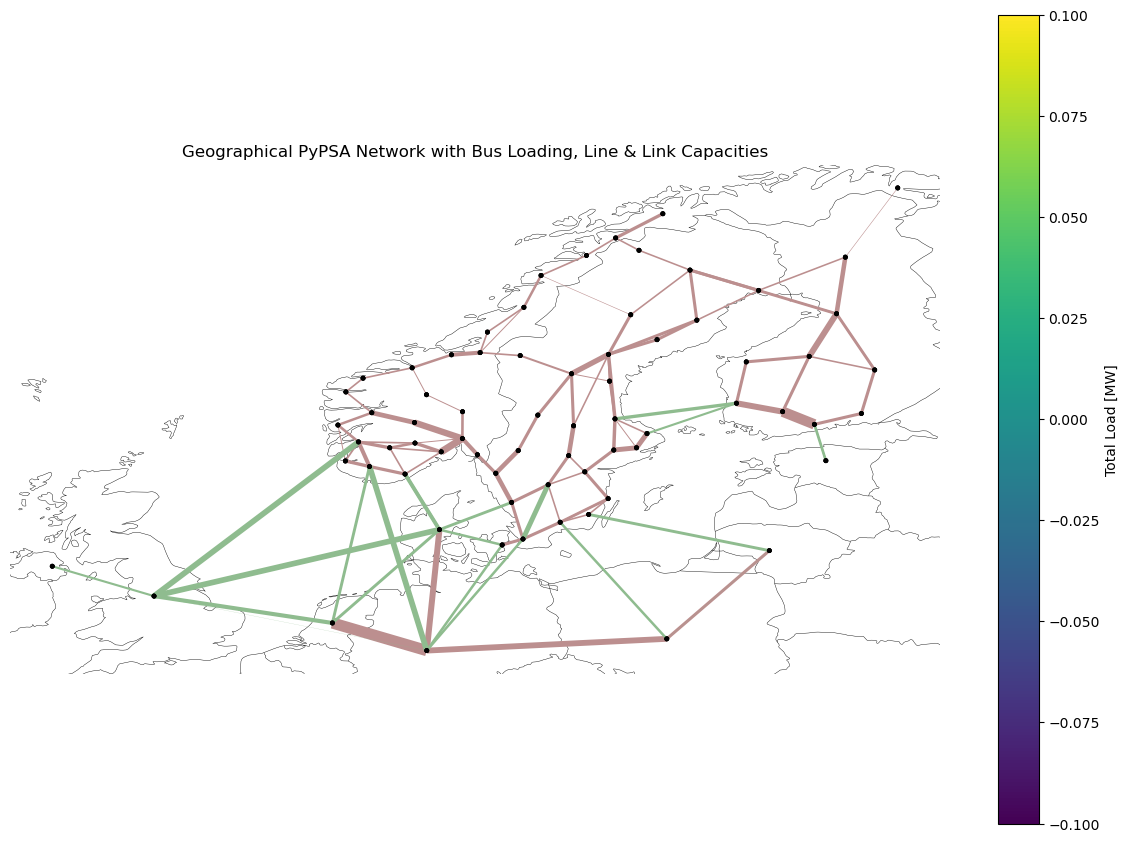

In [2]:


# Compute bus loading (sum over all time steps)
bus_loading = n.loads_t.p.sum(axis=0)  # MW per bus

# Extract line capacities
line_capacities = n.lines.s_nom.copy()
line_widths = 0.1 + 8 * line_capacities / line_capacities.max()

# Extract link capacities
if not n.links.empty:
    link_capacities = n.links.p_nom.copy()
    link_widths = 0.1 + 4 * link_capacities / link_capacities.max()
else:
    link_widths = None  # In case there are no links

# Create GeoAxes
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the network with buses, lines, and links
n.plot.map(ax=ax,
           bus_colors=bus_loading,
           bus_sizes=0.01,
           line_alpha=1,
           line_widths=line_widths,
           link_alpha=1,
           link_widths=link_widths)

# Add colorbar for bus loadings
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                           norm=plt.Normalize(vmin=bus_loading.min(),
                                              vmax=bus_loading.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Total Load [MW]")

plt.title("Geographical PyPSA Network with Bus Loading, Line & Link Capacities")
plt.show()


Text(0.5, 1.0, 'PyPSA Network with Bidding Zones, Bus Loading, Line & Link Capacities')

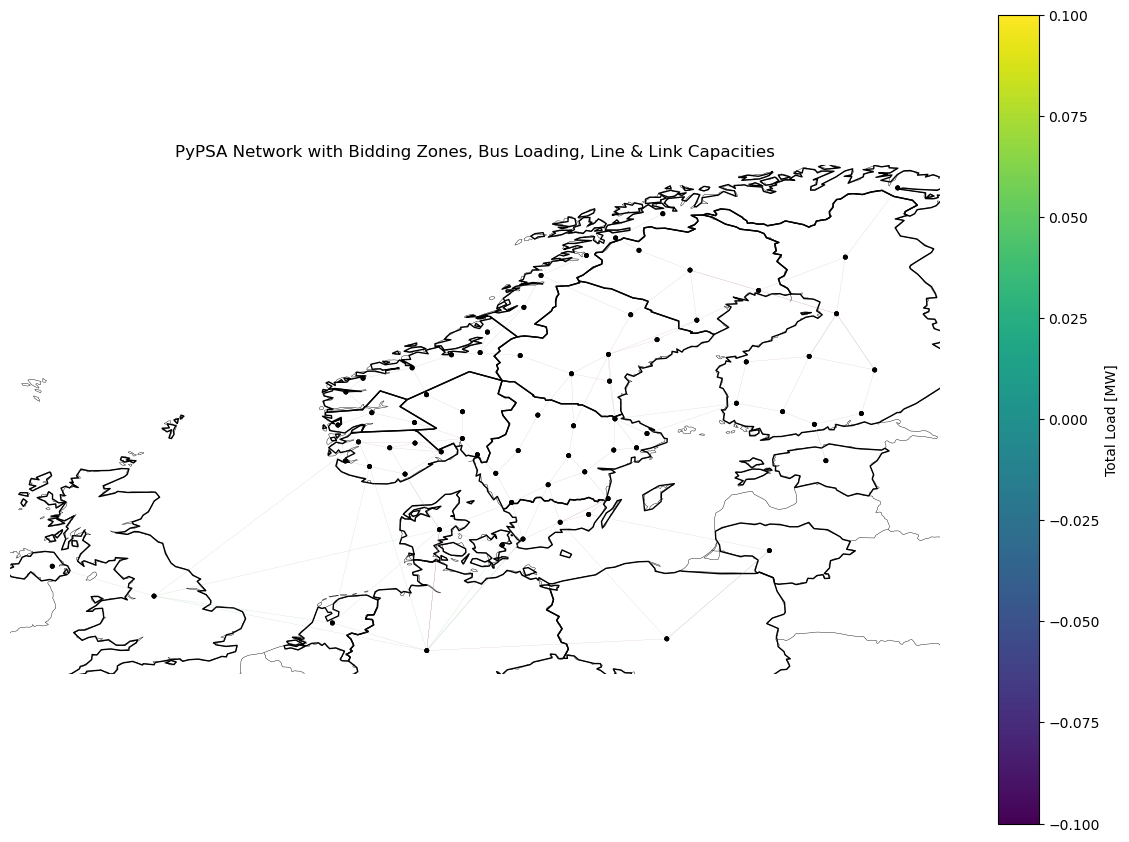

In [3]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np

# Load the bidding zones GeoJSON
zones_gdf = gpd.read_file(r"C:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\pypsa-eur\resources\NordicWeightedZonesTestDCLinksx\bidding_zones.geojson")

# Compute bus loading (sum over all time steps)
bus_loading = n.loads_t.p.sum(axis=0)  # MW per bus

# Extract line capacities
line_capacities = n.lines.s_nom.copy()
line_widths = 0.1 #+ 8 * line_capacities / line_capacities.max()

# Extract link capacities
if not n.links.empty:
    link_capacities = n.links.p_nom.copy()
    link_widths = 0.1 #+ 4 * link_capacities / link_capacities.max()
else:
    link_widths = None

# Create GeoAxes
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())

# --- Plot bidding zones (as polygons) ---
zones_gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)

# If you want filled colors per zone:
#zones_gdf.plot(ax=ax, column="name", legend=True, alpha=0.3)

# --- Plot the network ---
n.plot.map(ax=ax,
           bus_colors=bus_loading,
           bus_sizes=0.01,
           line_alpha=1,
           line_widths=line_widths,
           link_alpha=1,
           link_widths=link_widths)

# Add colorbar for bus loadings
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                           norm=plt.Normalize(vmin=bus_loading.min(),
                                              vmax=bus_loading.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Total Load [MW]")

plt.title("PyPSA Network with Bidding Zones, Bus Loading, Line & Link Capacities")
#plt.show()


In [4]:
import geopandas as gpd
from shapely.geometry import Point

# Load the bidding zones polygons
zones_gdf = gpd.read_file(r"C:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\pypsa-eur\resources\NordicWeightedZonesTestDCLinksx\bidding_zones.geojson")

# Convert buses to GeoDataFrame with Point geometry
bus_gdf = gpd.GeoDataFrame(
    n.buses.copy(),
    geometry=gpd.points_from_xy(n.buses.x, n.buses.y),
    crs=zones_gdf.crs
)

# Spatial join: assign each bus the zone it falls into
bus_with_zone = gpd.sjoin(bus_gdf, zones_gdf, how="left", predicate="within")

# Add zone info back to the network (use 'zone_name' from the geojson)
n.buses["zone"] = bus_with_zone["zone_name"]




In [5]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
n.buses.head()

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off,zone
Bus,,,,,,,,,,,,,,,,,
DE0 0,380.0,,9.207010,51.177778,AC,,,1.0,0.0,inf,Slack,,,DE,1.0,1.0,DE00
DK0 0,380.0,,9.727929,56.142471,AC,,,1.0,0.0,inf,PQ,,,DK,1.0,1.0,DKW1
DK1 0,380.0,,12.303316,55.515974,AC,,,1.0,0.0,inf,Slack,,,DK,1.0,1.0,NaN
EE2 0,380.0,,25.591409,58.974010,AC,,,1.0,0.0,inf,Slack,,,EE,1.0,1.0,EE00
FI1 0,380.0,,21.920495,61.332573,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI00


In [6]:
#Copying n to nw, for n working. Deleting bus in Northern Ireland and everything connected to it. 
nw = n.copy()
nw.remove("Bus", ["GB4 0"])



In [7]:
#Checking if GB4 0 was actually dropped. 
"GB4 0" in nw.buses.index


False

In [8]:
#Ignore this, it's trash for now
"""
# Recompute bus loading AFTER bus deletion
bus_loading = nw.loads_t.p.sum(axis=0)
bus_loading = bus_loading.reindex(nw.buses.index).fillna(0)

# Line widths
line_capacities = nw.lines.s_nom.copy()
line_widths = 0.1 + 8 * line_capacities / line_capacities.max()

# Link widths
if not nw.links.empty:
    link_capacities = nw.links.p_nom.copy()
    link_widths = 0.1 + 4 * link_capacities / link_capacities.max()
else:
    link_widths = None

# Plot
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.PlateCarree())

nw.plot.map(
    ax=ax,
    bus_colors=bus_loading,
    bus_sizes=0.01,
    line_alpha=1,
    line_widths=line_widths,
    link_alpha=1,
    link_widths=link_widths
)

# Colorbar
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=bus_loading.min(), vmax=bus_loading.max())
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Total Load [MW]")

plt.title("Geographical PyPSA Network with Bus Loading, Line & Link Capacities")
plt.show()
"""

'\n# Recompute bus loading AFTER bus deletion\nbus_loading = nw.loads_t.p.sum(axis=0)\nbus_loading = bus_loading.reindex(nw.buses.index).fillna(0)\n\n# Line widths\nline_capacities = nw.lines.s_nom.copy()\nline_widths = 0.1 + 8 * line_capacities / line_capacities.max()\n\n# Link widths\nif not nw.links.empty:\n    link_capacities = nw.links.p_nom.copy()\n    link_widths = 0.1 + 4 * link_capacities / link_capacities.max()\nelse:\n    link_widths = None\n\n# Plot\nfig = plt.figure(figsize=(15, 15))\nax = plt.axes(projection=ccrs.PlateCarree())\n\nnw.plot.map(\n    ax=ax,\n    bus_colors=bus_loading,\n    bus_sizes=0.01,\n    line_alpha=1,\n    line_widths=line_widths,\n    link_alpha=1,\n    link_widths=link_widths\n)\n\n# Colorbar\nsm = plt.cm.ScalarMappable(\n    cmap=plt.cm.viridis,\n    norm=plt.Normalize(vmin=bus_loading.min(), vmax=bus_loading.max())\n)\nsm.set_array([])\ncbar = plt.colorbar(sm, ax=ax, shrink=0.7)\ncbar.set_label("Total Load [MW]")\n\nplt.title("Geographical PyPSA 

In [9]:
#Deleting more buses in Northern Ireland, as this is what caused the node dot to still remain in the map after "deleting" bus4 0

nw.remove("Bus", ["GB4 0 H2", "GB4 0 battery"])
[b for b in nw.buses.index if "GB4" in b]


[]

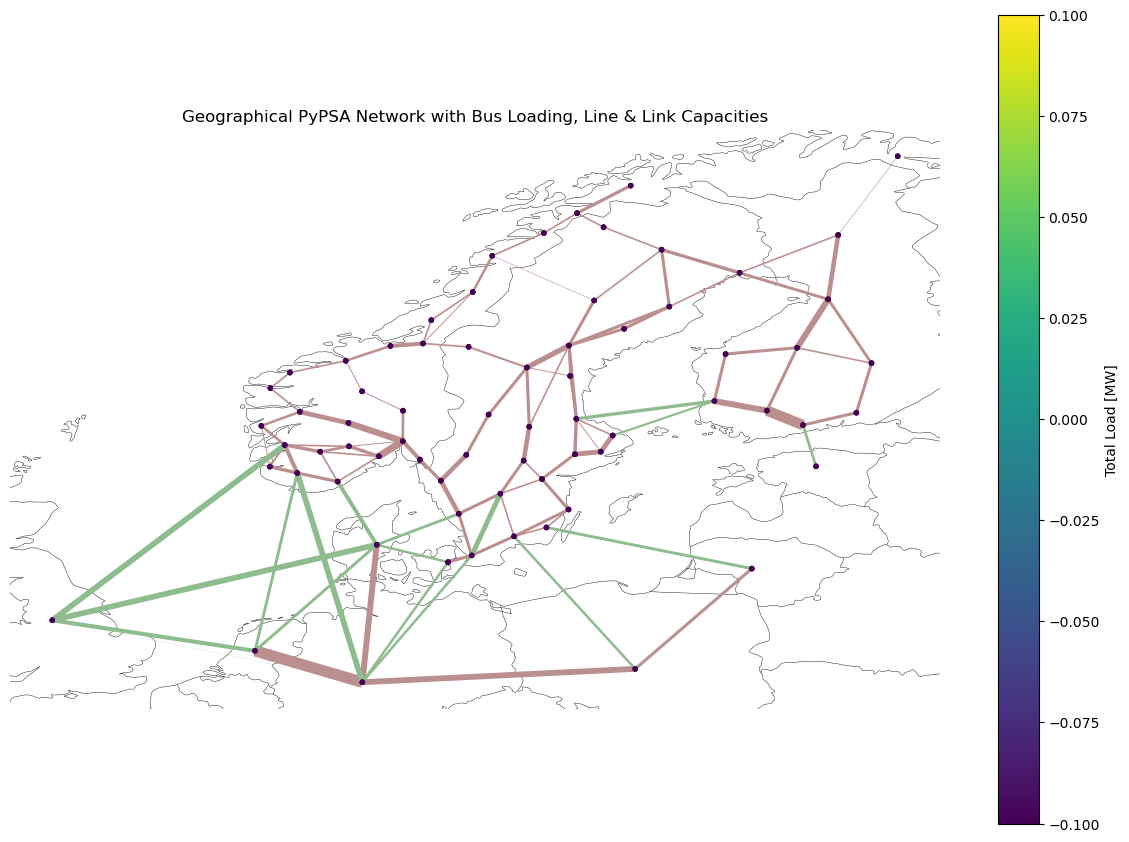

In [10]:
# Recompute bus loading AFTER bus deletion
bus_loading = nw.loads_t.p.sum(axis=0)
bus_loading = bus_loading.reindex(nw.buses.index).fillna(0)

# Line widths
line_capacities = nw.lines.s_nom.copy()
line_widths = 0.1 + 8 * line_capacities / line_capacities.max()

# Link widths
if not nw.links.empty:
    link_capacities = nw.links.p_nom.copy()
    link_widths = 0.1 + 4 * link_capacities / link_capacities.max()
else:
    link_widths = None

# Plot
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.PlateCarree())

nw.plot.map(
    ax=ax,
    bus_colors=bus_loading,
    bus_sizes=0.01,
    line_alpha=1,
    line_widths=line_widths,
    link_alpha=1,
    link_widths=link_widths
)

# Colorbar
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=bus_loading.min(), vmax=bus_loading.max())
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Total Load [MW]")

plt.title("Geographical PyPSA Network with Bus Loading, Line & Link Capacities")
plt.show()


In [11]:
#Deleting AC-lines in non-Nordic area

countries = ["DE", "PL", "LT", "EE", "NL", "DK"]

mask = (
    nw.lines.bus0.str[:2].isin(countries) |
    nw.lines.bus1.str[:2].isin(countries)
)

lines_to_remove = nw.lines.index[mask]
lines_to_remove
nw.remove("Line", lines_to_remove)

print(f"Removed {len(lines_to_remove)} lines connected to {countries}.")


Removed 7 lines connected to ['DE', 'PL', 'LT', 'EE', 'NL', 'DK'].


In [12]:
nw.lines.head()

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,s_nom_min,s_nom_max,s_max_pu,capital_cost,active,build_year,lifetime,length,carrier,terrain_factor,num_parallel,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,i_nom,dc
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,FI1 1,FI1 6,Al/St 240/40 4-bundle 380.0,0.000000,0.000000,0.0,0.000000,3396.210000,0.0,True,3396.210000,23396.210000,0.7,30.804548,True,2028,inf,267.658558,AC,1.0,2.000003,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380,2.58,NaN
100,SE1 25,SE1 9,Al/St 240/40 4-bundle 380.0,21.195140,4.224945,0.0,0.001106,983.112038,0.0,True,983.112038,20983.112038,0.7,16.208151,True,0,inf,140.831494,AC,1.0,0.578947,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380,2.58,0.0
101,SE1 3,SE1 7,Al/St 240/40 4-bundle 380.0,24.898959,3.036458,0.0,0.001755,3574.952867,0.0,True,3574.952867,23574.952867,0.7,23.297525,True,0,inf,202.430564,AC,1.0,2.105263,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380,2.58,0.0
11,FI1 1,FI1 8,Al/St 240/40 4-bundle 380.0,12.425188,1.515267,0.0,0.003504,7149.905734,0.0,True,7149.905734,27149.905734,0.7,23.252065,True,0,inf,202.035570,AC,1.0,4.210526,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380,2.58,0.0
12,FI1 1,FI1 8,Al/St 240/40 4-bundle 380.0,0.000000,0.000000,0.0,0.000000,3396.210000,0.0,True,3396.210000,23396.210000,0.7,23.252065,True,2022,inf,202.035570,AC,1.0,2.000003,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380,2.58,NaN


In [13]:
#Removing DC-links not connected to Nordic area
# Countries that should be kept
keep_countries = ["NO", "SE", "DK", "FI"]

# Identify DC links
mask_dc = nw.links.carrier.str.contains("DC", case=False, na=False)

# Identify DC links that have at least one bus in the keep list
mask_connected_to_nordic = (
    nw.links.bus0.str[:2].isin(keep_countries) |
    nw.links.bus1.str[:2].isin(keep_countries)
)

# Remove DC links NOT connected to any Nordic country
mask_to_remove = mask_dc & ~mask_connected_to_nordic
links_to_remove = nw.links.index[mask_to_remove]

nw.remove("Link", links_to_remove)

print(f"Removed {len(links_to_remove)} DC links not connected to {keep_countries}.")


Removed 4 DC links not connected to ['NO', 'SE', 'DK', 'FI'].


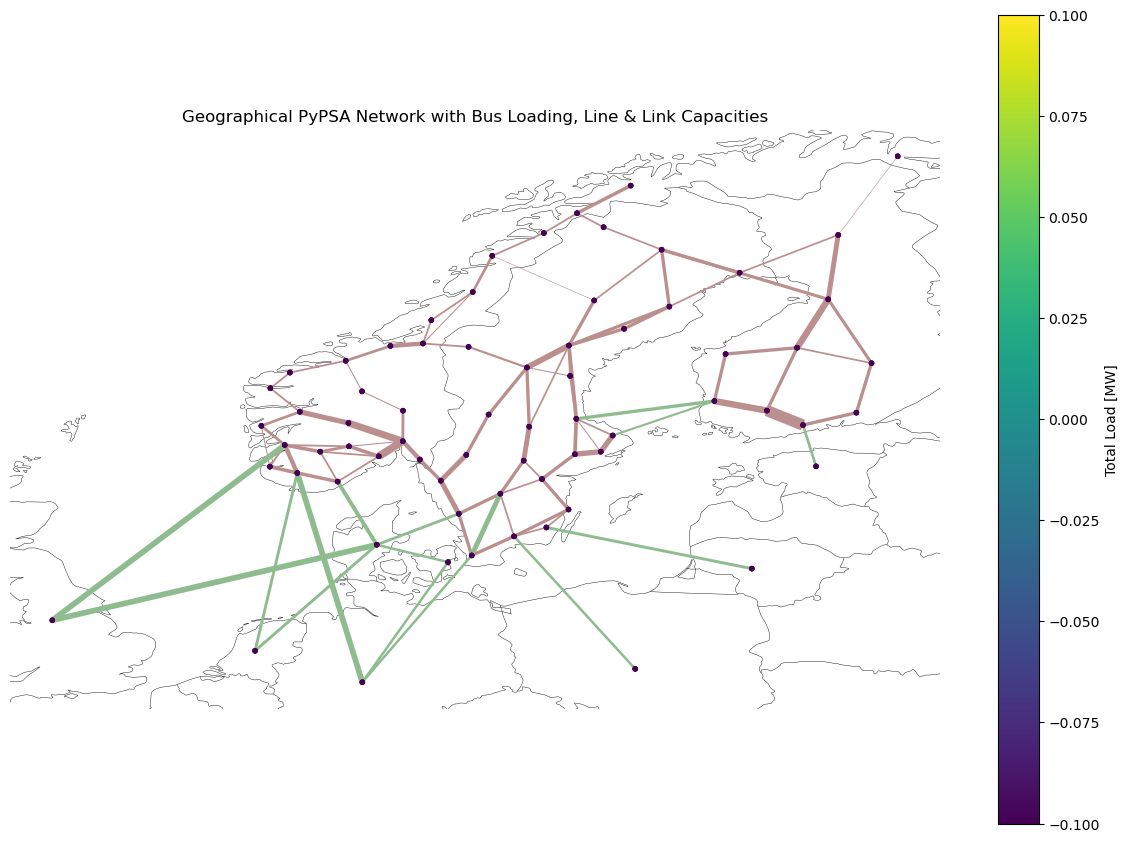

In [14]:
# Recompute bus loading AFTER bus deletion
bus_loading = nw.loads_t.p.sum(axis=0)
bus_loading = bus_loading.reindex(nw.buses.index).fillna(0)

# Line widths
line_capacities = nw.lines.s_nom.copy()
line_widths = 0.1 + 8 * line_capacities / line_capacities.max()

# Link widths
if not nw.links.empty:
    link_capacities = nw.links.p_nom.copy()
    link_widths = 0.1 + 4 * link_capacities / link_capacities.max()
else:
    link_widths = None

# Plot
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.PlateCarree())

nw.plot.map(
    ax=ax,
    bus_colors=bus_loading,
    bus_sizes=0.01,
    line_alpha=1,
    line_widths=line_widths,
    link_alpha=1,
    link_widths=link_widths
)

# Colorbar
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=bus_loading.min(), vmax=bus_loading.max())
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Total Load [MW]")

plt.title("Geographical PyPSA Network with Bus Loading, Line & Link Capacities")
plt.show()

In [15]:
norway_zone_map = {
    "NOS1": "NO1",
    "NOS2": "NO2",
    "NOS5": "NO5",
    "NOM1": "NO3",
    "NON1": "NO4"
}





In [17]:
# First assign subzones from the geojson
nw.buses["subzone"] = bus_with_zone["zone_name"]

# Then map to bidding zones
nw.buses["zone"] = nw.buses["subzone"].map(norway_zone_map).fillna(nw.buses["subzone"])


In [22]:
nw.buses
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

nw.buses


,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off,zone,subzone
Bus,,,,,,,,,,,,,,,,,,
DE0 0,380.0,,9.207010,51.177778,AC,,,1.0,0.0,inf,Slack,,,DE,1.0,1.0,DE00,DE00
DK0 0,380.0,,9.727929,56.142471,AC,,,1.0,0.0,inf,PQ,,,DK,1.0,1.0,DKW1,DKW1
DK1 0,380.0,,12.303316,55.515974,AC,,,1.0,0.0,inf,Slack,,,DK,1.0,1.0,NaN,NaN
EE2 0,380.0,,25.591409,58.974010,AC,,,1.0,0.0,inf,Slack,,,EE,1.0,1.0,EE00,EE00
FI1 0,380.0,,21.920495,61.332573,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI00,FI00
FI1 1,380.0,,26.029901,65.006504,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI00,FI00
FI1 2,380.0,,27.048256,60.911198,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI00,FI00
FI1 3,380.0,,26.390787,67.329240,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI00,FI00
FI1 4,380.0,,22.324444,63.030344,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI00,FI00


In [23]:
nw.generators['carrier'].unique()



array(['CCGT', 'OCGT', 'biomass', 'coal', 'lignite', 'oil', 'nuclear',
       'solar-hsat', 'onwind', 'offwind-float', 'offwind-ac', 'solar',
       'offwind-dc', 'ror'], dtype=object)

In [24]:

nw.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,e_sum_min,e_sum_max,q_set,sign,carrier,marginal_cost,marginal_cost_quadratic,active,build_year,lifetime,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DE0 0 CCGT,DE0 0,PQ,,27588.683094,0.0,True,27588.683094,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,CCGT,50.856734,0.0,True,0,inf,274.408214,0.540198,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0
DE0 0 OCGT,DE0 0,PQ,,23.310000,0.0,True,23.310000,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,OCGT,58.314663,0.0,True,0,inf,123.979495,0.458763,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0
DE0 0 biomass,DE0 0,PQ,,2299.507379,0.0,False,2299.507379,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,biomass,16.614361,0.0,True,0,inf,806.030277,0.449124,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0
DE0 0 coal,DE0 0,PQ,,18098.577228,0.0,False,18098.577228,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,coal,30.116182,0.0,True,0,inf,923.857609,0.355816,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0
DE0 0 lignite,DE0 0,PQ,,21701.743000,0.0,False,21701.743000,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,lignite,12.114074,0.0,True,0,inf,923.857609,0.376001,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0
DE0 0 oil,DE0 0,PQ,,2663.107710,0.0,False,2663.107710,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,oil,155.238677,0.0,True,0,inf,107.063782,0.355719,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0
DK0 0 CCGT,DK0 0,PQ,,775.200000,0.0,True,775.200000,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,CCGT,49.827795,0.0,True,0,inf,274.408214,0.544376,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0
DK0 0 biomass,DK0 0,PQ,,72.000000,0.0,False,72.000000,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,biomass,15.828205,0.0,True,0,inf,806.030277,0.468000,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0
DK0 0 coal,DK0 0,PQ,,1817.885609,0.0,False,1817.885609,inf,0.0,1.000,0.0,-inf,inf,0.0,1.0,coal,30.098840,0.0,True,0,inf,923.857609,0.356000,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.000000,0.0


In [25]:
#Checking to see if any of our buses are not connected to any links or lines
connected_buses = set(nw.lines.bus0) | set(nw.lines.bus1) | \
                  set(nw.links.bus0) | set(nw.links.bus1) | \
                  set(nw.generators.bus) | set(nw.loads.bus)

isolated_buses = nw.buses.index.difference(connected_buses)

print(f"Number of isolated buses: {len(isolated_buses)}")
if len(isolated_buses) > 0:
    print("Examples:")
    print(isolated_buses[:10])  # show first few



Number of isolated buses: 0


In [26]:
#Checking to see if any of our buses are not connected to any links or lines

connected_buses = (
    set(nw.lines.bus0) | set(nw.lines.bus1) |
    set(nw.links.bus0) | set(nw.links.bus1) |
    set(nw.generators.bus) | set(nw.loads.bus) |
    set(nw.storage_units.bus) | set(nw.transformers.bus0) | set(nw.transformers.bus1)
)

isolated_buses = nw.buses.index.difference(connected_buses)

print(f"Found {len(isolated_buses)} isolated buses.")


Found 0 isolated buses.
